# Quantum Sudoku Solver with Qiskit


In [77]:
# Install Qiskit if not already installed (uncomment if needed)
# !pip install qiskit

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeEssexV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, log2


# Diffusion function

In [53]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

# Oracle function
We'll encode the constraints (unique values in rows, columns, and boxes) as quantum logic

In [51]:
## Create constraints

clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)


def sudoku_oracle(qc, clause_list, clause_qubits, output_qubit):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mcx(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1



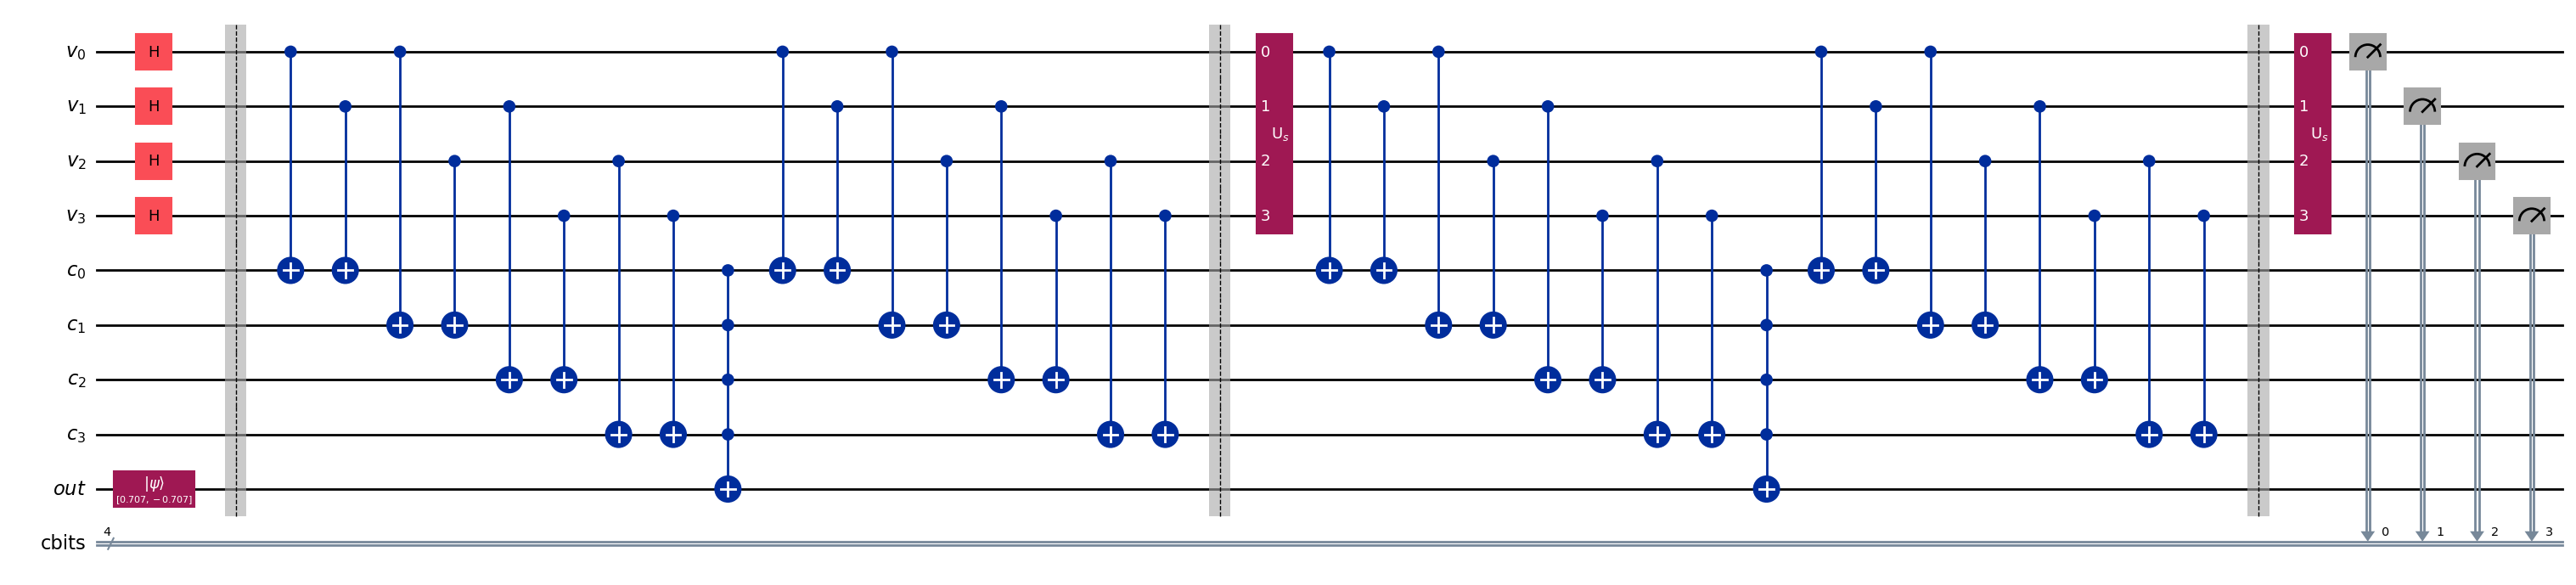

In [56]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

# do 2 iterations
for i in range(2):
    # Apply our oracle
    sudoku_oracle(qc, clause_list, clause_qubits, output_qubit)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl', fold=-1)

# Simulate

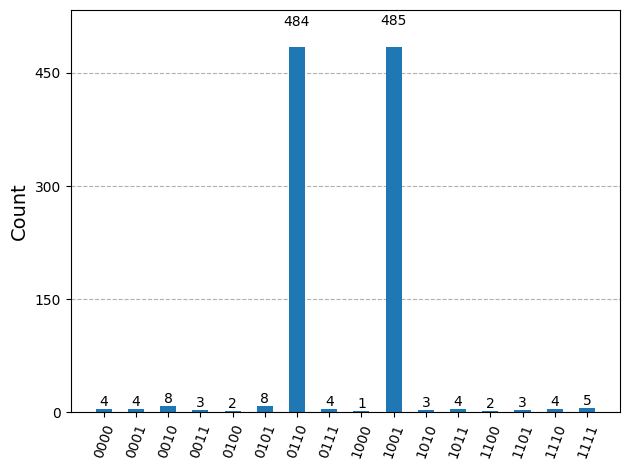

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-316 contains invalid parameters  for "stabilizer" method.
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-316 contains invalid parameters  for "stabilizer" method.
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-316 contains invalid parameters  for "stabilizer" method.


In [ ]:
qasm_simulator = AerSimulator()
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts())

# Solve with clues

In [72]:
# Define a sample 2x2 Sudoku puzzle (0 = empty)
sudoku = np.array([
    [0, 0],
    [0, 2],
])
print("Initial 2x2 Sudoku Puzzle:")
print(sudoku)

# Flatten the sudoku array to a single list (row-major order)
clues = sudoku.flatten().tolist()

def initialize(qc, var_qubits, clues):
    # Initialize variable qubits according to sudoku clues
    # For 2x2 sudoku, clues are in sudoku[0,0], sudoku[0,1], sudoku[1,0], sudoku[1,1]
    # Each cell is encoded as 2 qubits: value 1 -> 0, 2 -> 1
    for bidx, v in enumerate(clues):
        if v == 0:
            qc.h(var_qubits[bidx])
        elif v == 2:
            qc.x(var_qubits[bidx])
        # for 1 do nothing
    


Initial 2x2 Sudoku Puzzle:
[[0 0]
 [0 2]]


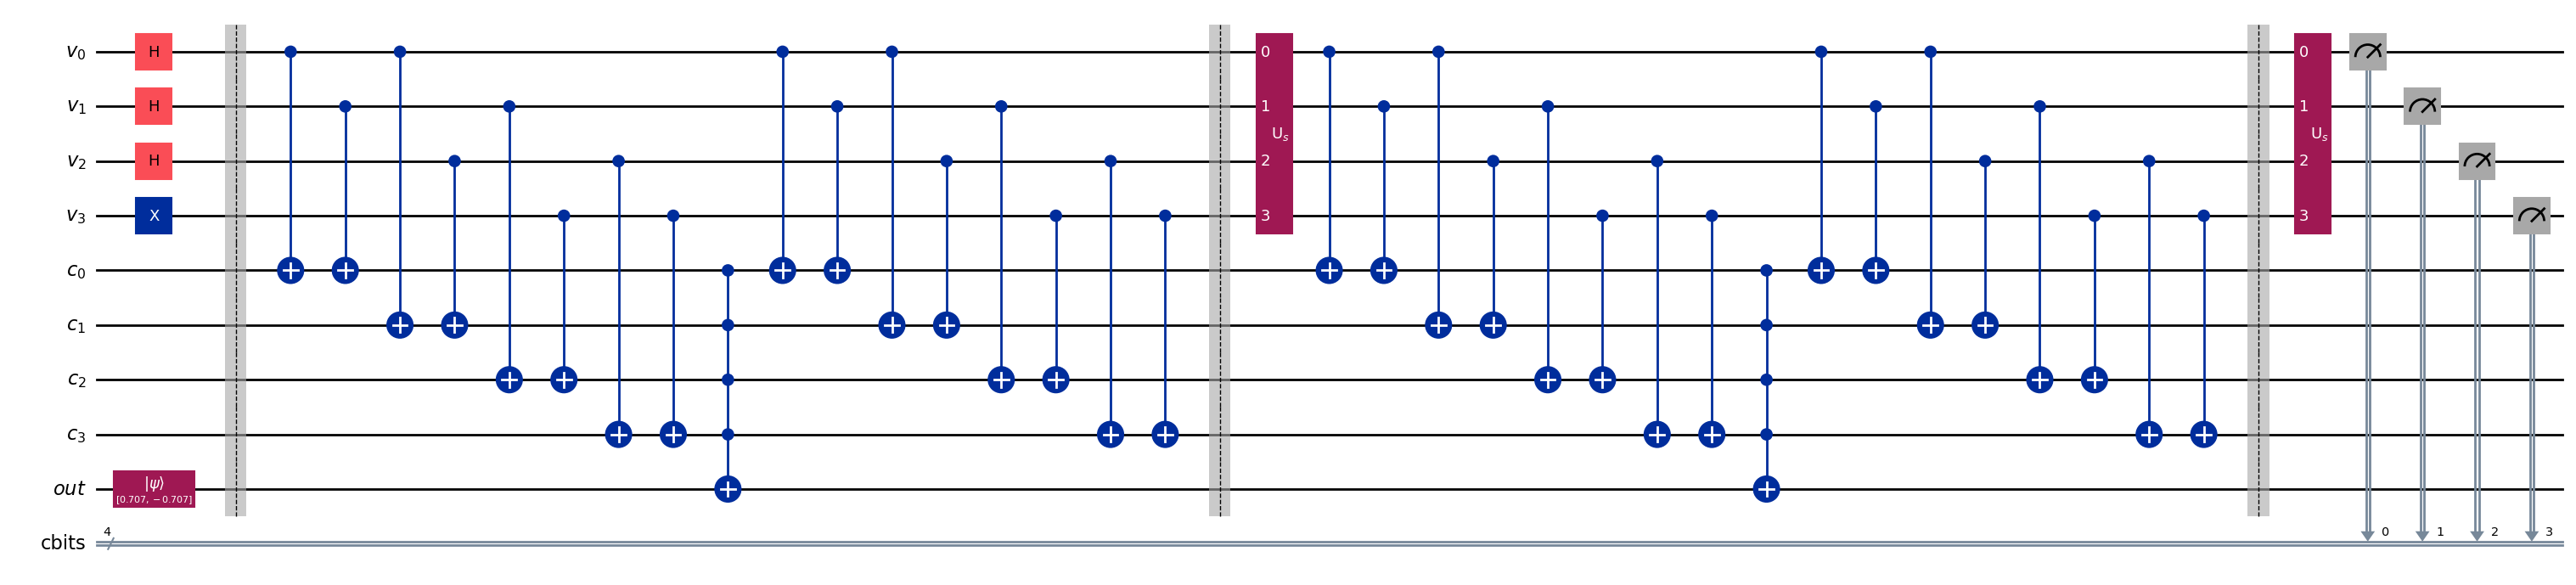

In [73]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
initialize(qc, var_qubits, clues)

qc.barrier()  # for visual separation

# do 2 iterations
for i in range(2):
    # Apply our oracle
    sudoku_oracle(qc, clause_list, clause_qubits, output_qubit)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl', fold=-1)

Solved Sudoku:
[[2 1]
 [1 2]]


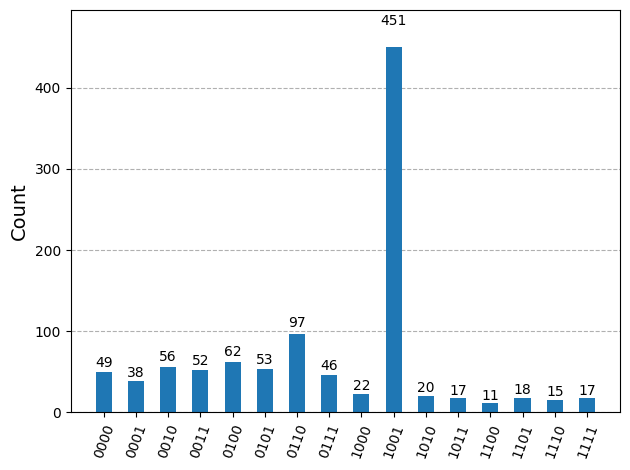

In [74]:
qasm_simulator = AerSimulator()
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()

# Get the most probable bitstring
counts = result.get_counts()
max_bitstring = max(counts, key=counts.get)

# Convert bitstring to list of ints (reverse if needed to match qubit order)
bits = [int(b) for b in max_bitstring[::-1]]

# For 2x2 sudoku, each cell is 1 bit (since only 1 or 2 allowed), but here 4 qubits for 4 cells
# Reshape to 2x2 array and add 1 to match sudoku values (1 or 2)
sudoku_solution = np.array(bits).reshape(2, 2) + 1

print("Solved Sudoku:")
print(sudoku_solution)

plot_histogram(result.get_counts())


# Sudoku 4x4

In [82]:
# adjust XOR for multi bit values

tag_list = {}

def allocate(qc, num_qbits, tag):
    if tag not in tag_list:
        reg = QuantumRegister(num_qbits, tag)
        qc.add_register(reg)
        tag_list[tag]=reg
    return tag_list[tag]

def XOR(qc, a, b, output):
    if type(a) == int and type(b) == int:
        qc.cx(a, output)
        qc.cx(b, output)
    else: # assume 2 bits per variable a & b
        t = allocate(qc, 2, 't')
        qc.cx(a[0], t[0]); qc.cx(b[0], t[0])  # t0 = a0 XOR b0
        qc.cx(a[1], t[1]); qc.cx(b[1], t[1])  # t1 = a1 XOR b1
        qc.x(t[0]); qc.x(t[1])            # now t0=1 iff low bits equal, t1=1 iff high bits equal
        qc.ccx(t[0], t[1], output)        # eq = t0 AND t1  (a==b)
        # uncompute t0 and t1 
        qc.cx(a[1], t[1])
        qc.cx(b[1], t[1])
        qc.cx(a[0], t[0])
        qc.cx(b[0], t[0])
        



In [103]:
# create clause list for all rows, cols and blocks
# For 4x4 sudoku, each cell is represented by 2 qubits (so 16 variables, 32 qubits)
# We'll create clauses to ensure all cells in each row, column, and block are unique

clause_set = set()
cells = [(2*i, 2*i+1) for i in range(16)]  # 16 cells, each with 2 qubits

# Helper to add all pairs from a list to clause_set
def add_all_pairs(indices):
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            clause_set.add((indices[i], indices[j]))

# Rows
for r in range(4):
    row_cells = [4*r + c for c in range(4)]
    add_all_pairs(row_cells)

# Columns
for c in range(4):
    col_cells = [4*r + c for r in range(4)]
    add_all_pairs(col_cells)

# 2x2 Blocks
for br in range(2):
    for bc in range(2):
        block_cells = []
        for dr in range(2):
            for dc in range(2):
                block_cells.append(4*(2*br+dr) + (2*bc+dc))
        add_all_pairs(block_cells)

# Now clause_set contains all pairs of cell indices that must be different
# To use with qubits, map cell index to its 2-qubit tuple
clause_list = []
for a, b in clause_set:
    clause_list.append([cells[a], cells[b]])

print(f"clause_list {len(clause_list)}: {clause_list}")


clause_list 56: [[(6, 7), (14, 15)], [(8, 9), (12, 13)], [(24, 25), (26, 27)], [(8, 9), (24, 25)], [(10, 11), (14, 15)], [(10, 11), (26, 27)], [(0, 1), (4, 5)], [(16, 17), (18, 19)], [(0, 1), (10, 11)], [(16, 17), (24, 25)], [(18, 19), (22, 23)], [(0, 1), (16, 17)], [(22, 23), (28, 29)], [(2, 3), (6, 7)], [(2, 3), (18, 19)], [(4, 5), (28, 29)], [(26, 27), (28, 29)], [(20, 21), (30, 31)], [(12, 13), (28, 29)], [(8, 9), (10, 11)], [(10, 11), (12, 13)], [(8, 9), (16, 17)], [(24, 25), (30, 31)], [(6, 7), (12, 13)], [(10, 11), (18, 19)], [(28, 29), (30, 31)], [(6, 7), (30, 31)], [(16, 17), (22, 23)], [(0, 1), (2, 3)], [(18, 19), (20, 21)], [(2, 3), (4, 5)], [(20, 21), (22, 23)], [(0, 1), (8, 9)], [(18, 19), (26, 27)], [(2, 3), (10, 11)], [(20, 21), (28, 29)], [(4, 5), (14, 15)], [(4, 5), (20, 21)], [(12, 13), (14, 15)], [(12, 13), (20, 21)], [(14, 15), (30, 31)], [(8, 9), (14, 15)], [(24, 25), (28, 29)], [(6, 7), (22, 23)], [(0, 1), (6, 7)], [(16, 17), (20, 21)], [(18, 19), (24, 25)], [(2, 

In [105]:

def and_all_flags(qc, clause_qubits, allgood_qubit):
    """
    Compute logical AND of all clause_qubits into allgood_qubit using a binary tree of Toffolis.
    - qc: QuantumCircuit
    - clause_qubits: list or QuantumRegister of clause flag qubits
    - allgood_qubit: target qubit for the AND result
    """

    # tree_qubits: list of ancilla qubits for intermediate results (length at least len(clause_qubits)-1)
    num_tree_qubits = sum([ceil(len(clause_qubits)/(2**idx)) for idx in range(ceil(log2(len(clause_qubits)))-1)])  
    tree_qubits = allocate(qc, num_tree_qubits, 'tr')
    n = len(clause_qubits)
    if n == 1:
        qc.cx(clause_qubits[0], allgood_qubit)
        return

    # Prepare a list to hold intermediate results
    current_layer = list(clause_qubits)
    next_layer = []
    anc_idx = 0

    # Build the binary tree
    while len(current_layer) > 1:
        next_layer = []
        for i in range(0, len(current_layer), 2):
            if i+1 < len(current_layer):
                if len(current_layer) == 2:
                    # Last layer: output to allgood_qubit
                    qc.ccx(current_layer[i], current_layer[i+1], allgood_qubit)
                else:
                    qc.ccx(current_layer[i], current_layer[i+1], tree_qubits[anc_idx])
                    next_layer.append(tree_qubits[anc_idx])
                    anc_idx += 1
            else:
                # Odd number, propagate last qubit
                next_layer.append(current_layer[i])
        current_layer = next_layer

    # Uncompute ancilla tree bits (reverse the tree)
    # We need to reverse the operations in the opposite order
    # Rebuild the tree structure to know which ancilla was used at each layer
    layers = []
    n = len(clause_qubits)
    current_layer = list(clause_qubits)
    anc_idx = 0
    while len(current_layer) > 1:
        next_layer = []
        layer_ops = []
        for i in range(0, len(current_layer), 2):
            if i+1 < len(current_layer):
                if len(current_layer) == 2:
                    # Last layer: output to allgood_qubit
                    layer_ops.append((current_layer[i], current_layer[i+1], allgood_qubit))
                else:
                    layer_ops.append((current_layer[i], current_layer[i+1], tree_qubits[anc_idx]))
                    next_layer.append(tree_qubits[anc_idx])
                    anc_idx += 1
            else:
                next_layer.append(current_layer[i])
        layers.append(layer_ops)
        current_layer = next_layer

    # Uncompute in reverse order, skip the last layer (output to allgood_qubit)
    for layer_ops in reversed(layers[:-1]):
        for a, b, target in reversed(layer_ops):
            qc.ccx(a, b, target)

In [80]:
def sudoku_oracle(qc, clause_list, output_qubit):
    clause_qubits = allocate(qc, len(clause_list), 'c')
    
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    and_all_flags(qc, clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

In [109]:
# create clues

# Define a sample 2x2 Sudoku puzzle (0 = empty)
sudoku = np.array([
    [1, 0, 0, 4],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [3, 0, 0, 2]
])
print("Initial 4x4 Sudoku Puzzle:")
print(sudoku)

def initialize(qc, var_qubits, clues):
    # For 4x4 sudoku, each cell is encoded as 2 qubits (values 1-4)
    # clues: list of 16 values (0 for empty, 1-4 for clues)
    # var_qubits: QuantumRegister of length 32 (2 qubits per cell)
    for cell_idx, v in enumerate(clues):
        q0 = var_qubits[2 * cell_idx]
        q1 = var_qubits[2 * cell_idx + 1]
        if v == 0:
            # No clue: put both qubits in superposition
            qc.h(q0)
            qc.h(q1)
        else:
            # v in 1..4, encode as binary (1->00, 2->01, 3->10, 4->11)
            bin_val = v - 1
            if bin_val & 0b01:
                qc.x(q0)
            if bin_val & 0b10:
                qc.x(q1)

Initial 4x4 Sudoku Puzzle:
[[1 0 0 4]
 [0 0 0 0]
 [0 0 0 0]
 [3 0 0 2]]


In [116]:
tag_list = {}


# Flatten the sudoku array to a single list (row-major order)
clues = sudoku.flatten().tolist()

var_qubits = QuantumRegister(32, name='v')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(32, name='cbits')
qc = QuantumCircuit(var_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
initialize(qc, var_qubits, clues)

qc.barrier()  # for visual separation

# do 2 iterations
for i in range(2):
    # Apply our oracle
    sudoku_oracle(qc, clause_list, output_qubit)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

print("Number of qubits:", qc.num_qubits)
print("Number of gates:", qc.size())

# qc.draw('mpl', fold=-1)

Number of qubits: 200
Number of gates: 2745


In [122]:
# For a 4x4 Sudoku circuit with 200 qubits and 2745 gates, you need a simulator that supports large numbers of qubits.
# Qiskit AerSimulator (statevector method) supports up to MAX_QUBITS_STATEVECTOR (typically 29 on most machines).
# For 200 qubits, you need a simulator that supports "stabilizer" or "matrix product state (MPS)" methods, or a high-performance cluster.
qasm_simulator = AerSimulator(method='stabilizer')

# In Qiskit, use AerSimulator with the "mps" method for large circuits:
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()


# Get the most probable bitstring
counts = result.get_counts()
max_bitstring = max(counts, key=counts.get)

# Each cell is encoded as 2 bits (for values 1-4)
bits = [int(b) for b in max_bitstring[::-1]]
cell_values = []
for i in range(16):
    low = bits[2*i]
    high = bits[2*i+1]
    val = (high << 1) | low
    cell_values.append(val + 1)  # values are 1-4

sudoku_solution = np.array(cell_values).reshape(4, 4)

print("Solved Sudoku:")
print(sudoku_solution)

plot_histogram(result.get_counts())

QiskitError: 'ERROR:  [Experiment 0] Circuit circuit-316 contains invalid parameters  for "stabilizer" method. ,  ERROR: Circuit circuit-316 contains invalid parameters  for "stabilizer" method.'